<a href="https://colab.research.google.com/github/stephanieekekwe/Explanatory-Data-Analysis-on-Boston-Data-Crimes-Analysis/blob/master/semantic%20similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intorduction
This Explanatory Data Analysis looks at crime incident reports in the city of Boston from June 2015 to September 2018. I use Folium for plotting an interactive heatmap of Boston, and seaborn for everything else.

The dataset used in this notebook was gotten from kaggle [Crimes in Bostom](https://www.kaggle.com/AnalyzeBoston/crimes-in-boston)

In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud ,STOPWORDS, ImageColorGenerator
import seaborn as sns
%matplotlib inline
import folium
from folium.plugins import HeatMap
p = "YlGnBu"
p2 = "YlGn"
p3 = "Greys"
p4="viridis"
p5="coolwarm"


In [ ]:
data = pd.read_csv('crime.csv', encoding='iso-8859-1')
data

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319068,I050310906-00,3125,Warrant Arrests,WARRANT ARREST,D4,285,NaN,2016-06-05 17:25:00,2016,6,Sunday,17,Part Three,COVENTRY ST,42.336951,-71.085748,"(42.33695098, -71.08574813)"
319069,I030217815-08,111,Homicide,"MURDER, NON-NEGLIGIENT MANSLAUGHTER",E18,520,NaN,2015-07-09 13:38:00,2015,7,Thursday,13,Part One,RIVER ST,42.255926,-71.123172,"(42.25592648, -71.12317207)"
319070,I030217815-08,3125,Warrant Arrests,WARRANT ARREST,E18,520,NaN,2015-07-09 13:38:00,2015,7,Thursday,13,Part Three,RIVER ST,42.255926,-71.123172,"(42.25592648, -71.12317207)"
319071,I010370257-00,3125,Warrant Arrests,WARRANT ARREST,E13,569,NaN,2016-05-31 19:35:00,2016,5,Tuesday,19,Part Three,NEW WASHINGTON ST,42.302333,-71.111565,"(42.30233307, -71.11156487)"


In [ ]:
data_offense_codes = pd.read_csv('offense_codes.csv', encoding='iso-8859-1')
data_offense_codes.head()

,CODE,NAME
0,612,LARCENY PURSE SNATCH - NO FORCE
1,613,LARCENY SHOPLIFTING
2,615,LARCENY THEFT OF MV PARTS & ACCESSORIES
3,1731,INCEST
4,3111,LICENSE PREMISE VIOLATION


### Data Cleaning 
**I am going to focus on the two years with complete data (2016 and 2017). I will also narrow in on UCR Part One offenses, which include only the most serious crimes.**

In [ ]:
# Keep only data from complete years (2016, 2017)
data = data.loc[data['YEAR'].isin([2016,2017])]
data=data[data["UCR_PART"]=='Part One']
#drop shootings because it is 100% NAN
data = data.drop(['INCIDENT_NUMBER','OFFENSE_CODE','UCR_PART','Location','SHOOTING'], axis=1)
data['OCCURRED_ON_DATE'] = pd.to_datetime(data['OCCURRED_ON_DATE'])
# Convert DAY_OF_WEEK to an ordered category
data['DAY_OF_WEEK'] = pd.Categorical(data.DAY_OF_WEEK, 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

# Replace -1 values in Lat/Long with Nan
data.Lat.replace(-1, None, inplace=True)
data.Long.replace(-1, None, inplace=True)

# Rename columns to something easier to type (the all-caps are annoying!)
rename = {'OFFENSE_CODE_GROUP':'Group',
         'OFFENSE_DESCRIPTION':'Description',
         'DISTRICT':'District',
         'REPORTING_AREA':'Area',
         'SHOOTING':'Shooting',
         'OCCURRED_ON_DATE':'Date',
         'YEAR':'Year',
         'MONTH':'Month',
         'DAY_OF_WEEK':'Day',
         'HOUR':'Hour',
         'STREET':'Street'}
data.rename(index=str, columns=rename, inplace=True)

# Check
data['Group'].value_counts()

Larceny                       15709
Larceny From Motor Vehicle     6707
Aggravated Assault             4769
Residential Burglary           3309
Auto Theft                     2930
Robbery                        2882
Commercial Burglary             863
Other Burglary                  268
Homicide                        101
Name: Group, dtype: int64

In [ ]:
data.dtypes
data.isnull().sum()
data.shape

(37538, 12)

###Serious crimes
Let's start by checking the frequency of different types of crimes. Since we have subsetted to only 'serious' crimes, there are only 9 different types of offenses - much more manageable than the 67 we started with.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

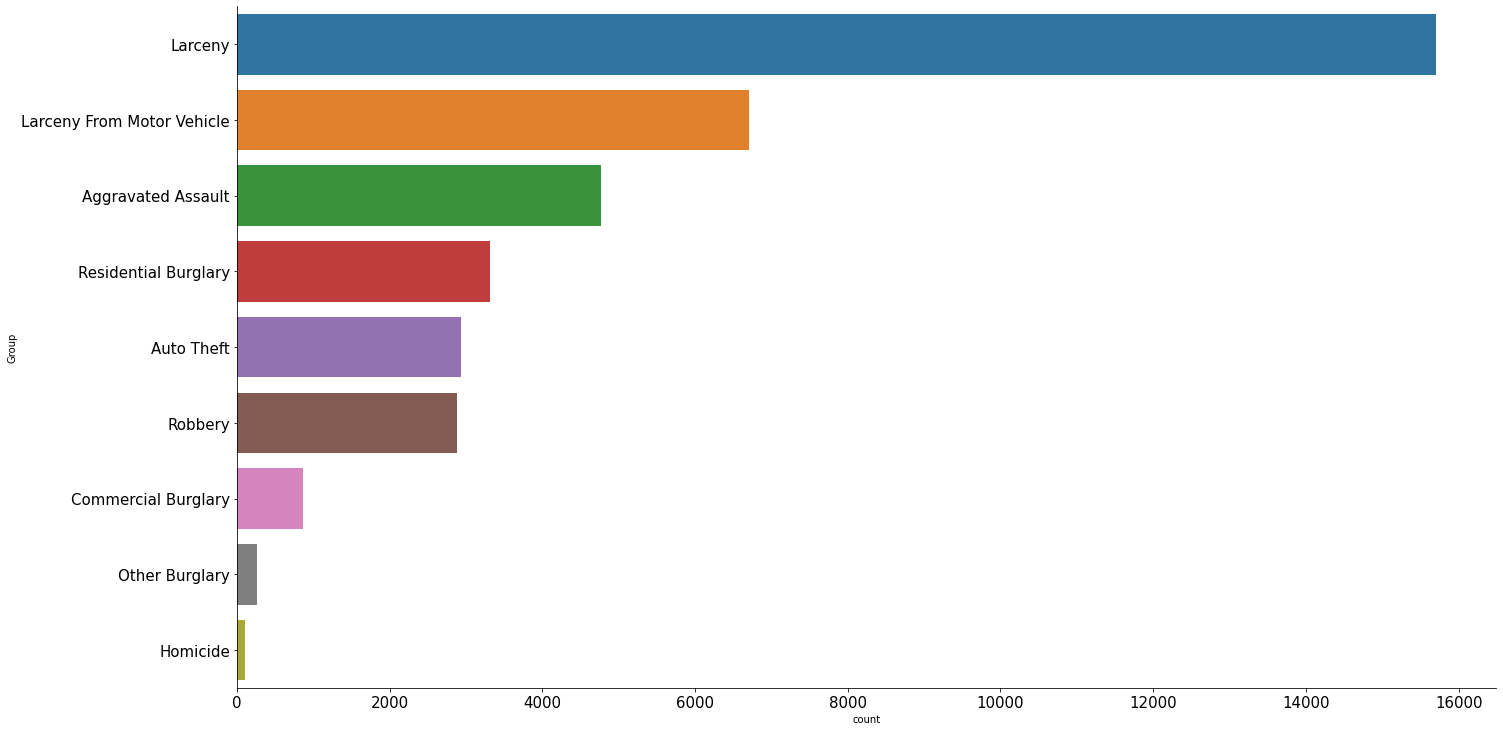

In [ ]:
sns.catplot(y='Group', kind='count', height=10, aspect=2.0, order=data.Group.value_counts().index,  data=data)
plt.xticks(size=15)
plt.yticks(size=15)

### At What do Crimes occure?
We can consider patterns across several different time scales: hours of the day, days of the week, and months of the year.



Text(-2.575000000000017, 0.5, 'Count')

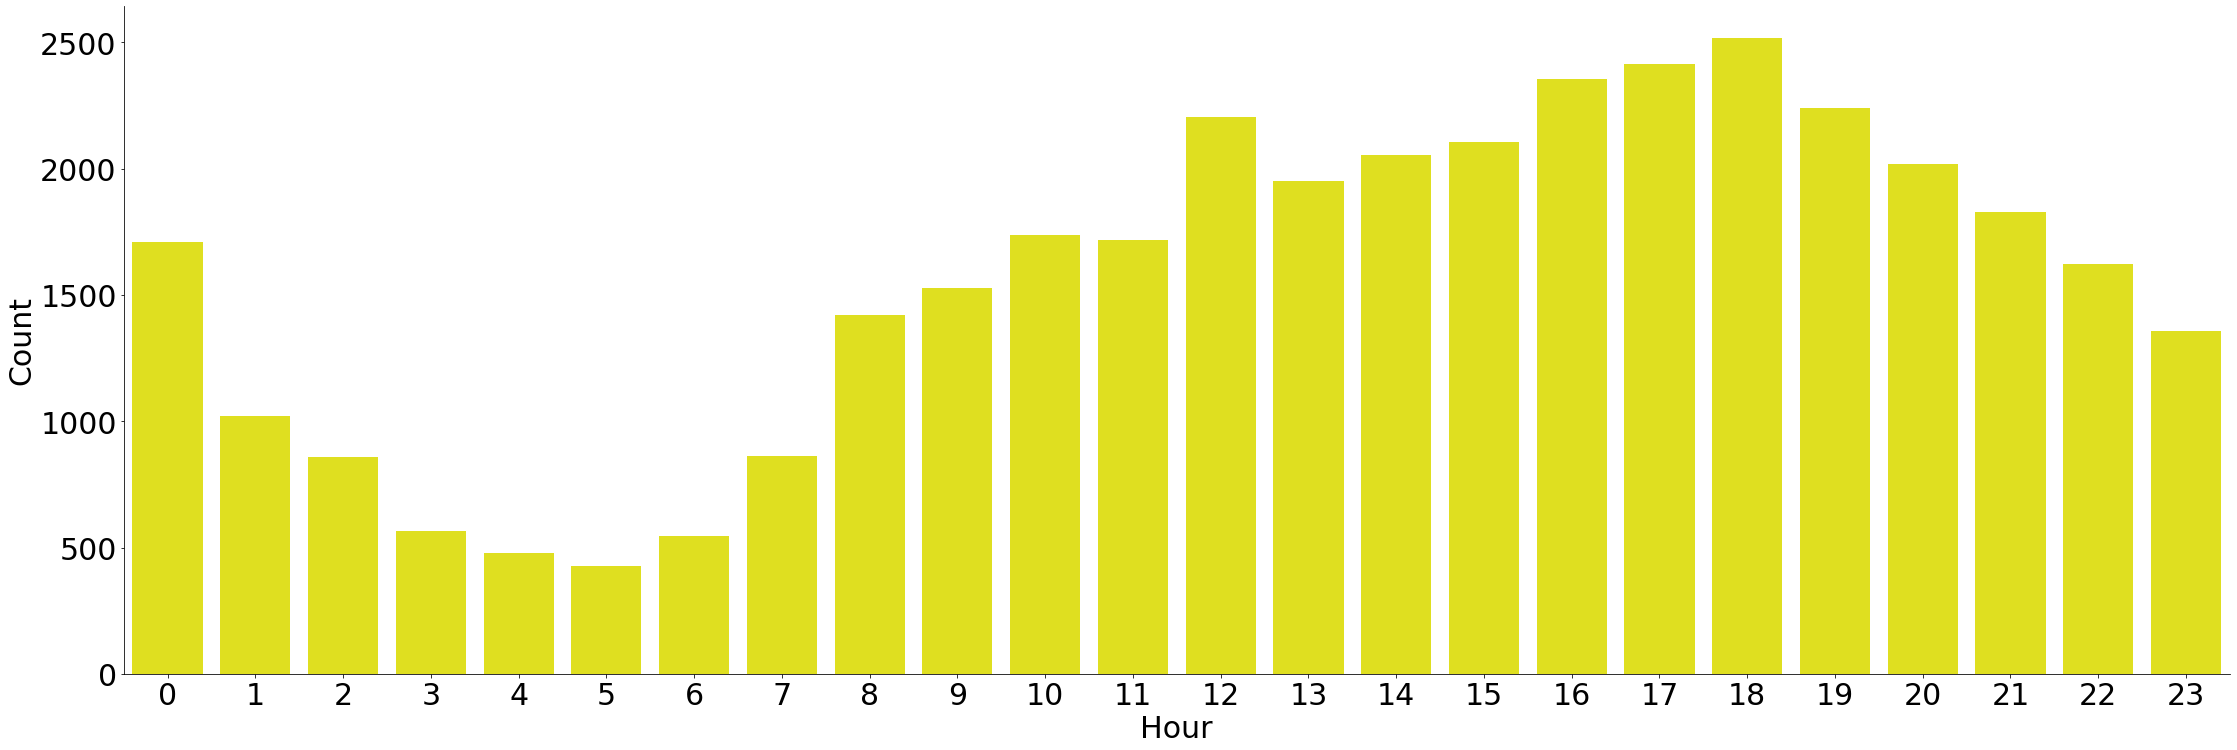

In [ ]:
sns.catplot(x='Hour',
           kind='count',
            height=10, 
            aspect=3,
            color='yellow',
           data=data)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Hour', fontsize=30)
plt.ylabel('Count', fontsize=30)

Text(-2.450000000000017, 0.5, 'Count')

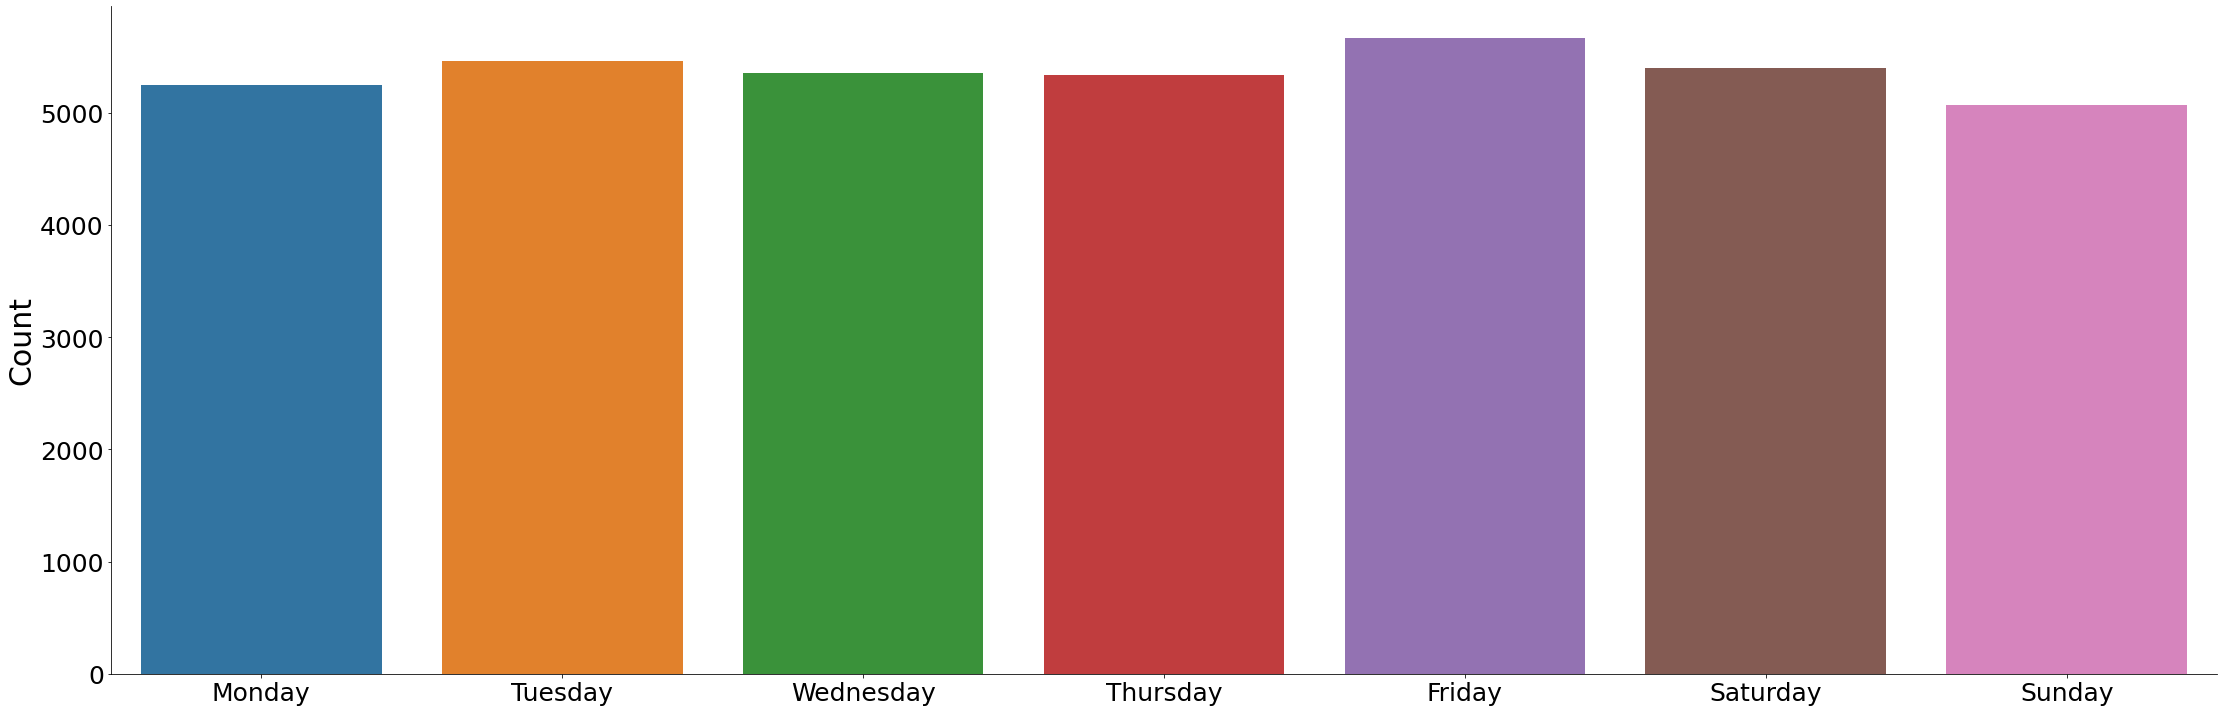

In [ ]:
sns.catplot(x='Day',
           kind='count',
            height=10, 
            aspect=3,
           data=data)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('')
plt.ylabel('Count', fontsize=30)

In [ ]:
x=data.groupby('Group')['Day'].value_counts()
x= pd.DataFrame(x)

Text(-2.575000000000003, 0.5, 'Count')

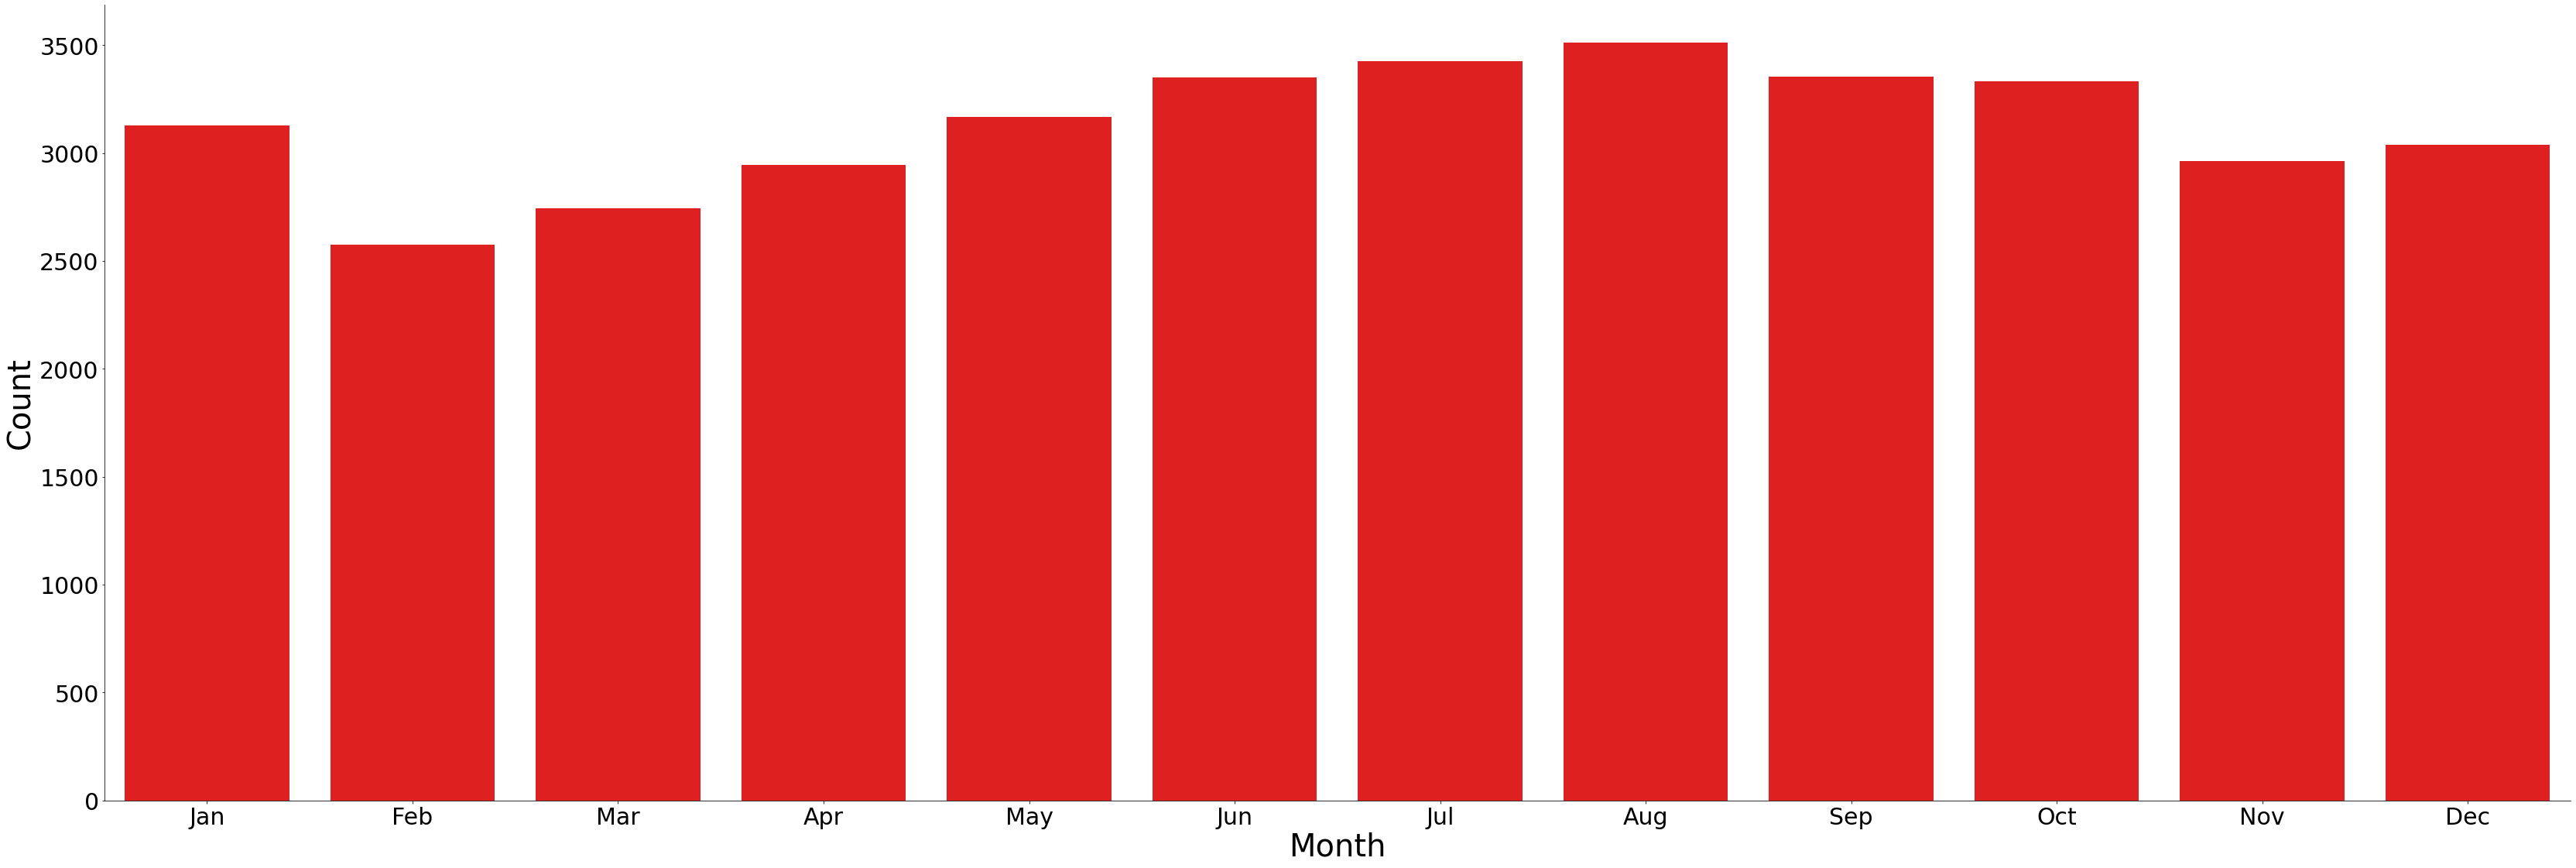

In [ ]:
Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

sns.catplot(x='Month',
           kind='count',
            height=15, 
            aspect=3,
            color='red',
           data=data)
plt.xticks(np.arange(12), Months, size=30)

# plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Month', fontsize=40)
plt.ylabel('Count', fontsize=40)

**Crimes rates are low between 1-8 in the morning, and gradually rise throughout the day, peaking around 6 pm. There is some variation across days of the week, with Friday having the highest crime rate and Sunday having the lowest. The month also seems to have some influence, with the winter months of February-April having the lowest crime rates, and the summer/early fall months of June-October having the highest crime rates. There is also a spike in crime rates in the month of January.**

In [ ]:
#Create data for plotting
data['Day_of_year'] = data["Date"].dt.dayofyear
data_holidays = data[data.Year == 2017].groupby(['Day_of_year']).size().reset_index(name='counts')

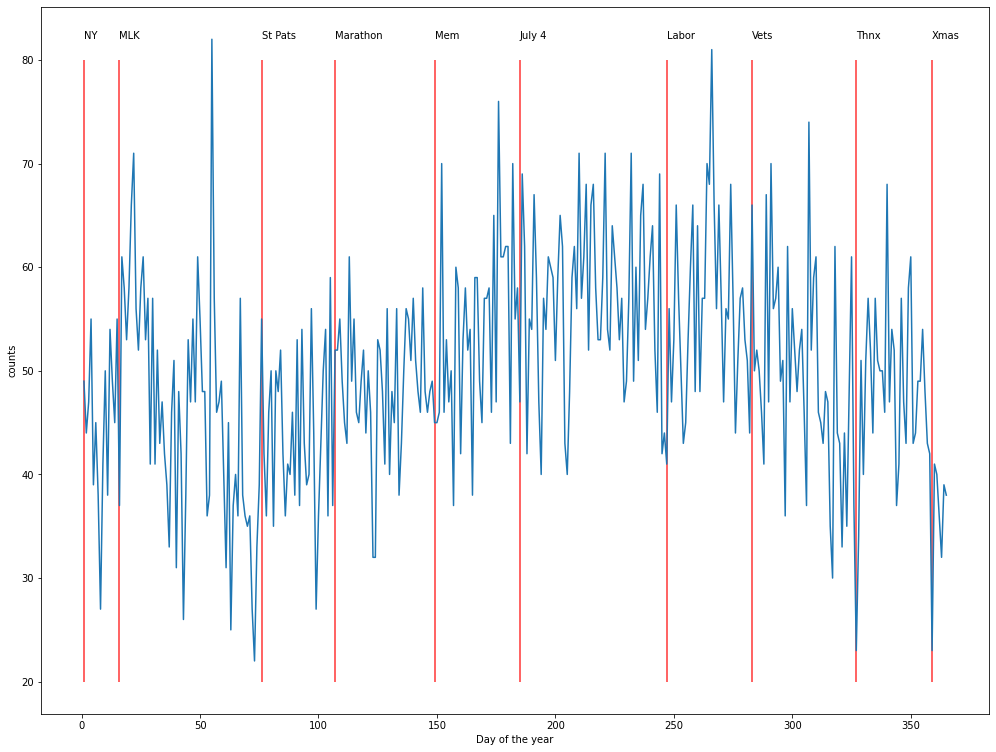

In [ ]:
# Dates of major U.S. holidays in 2017
holidays = pd.Series(['2017-01-01', # New Years Day
                     '2017-01-16', # MLK Day
                     '2017-03-17', # St. Patrick's Day
                     '2017-04-17', # Boston marathon
                     '2017-05-29', # Memorial Day
                     '2017-07-04', # Independence Day
                     '2017-09-04', # Labor Day
                     '2017-10-10', # Veterans Day
                     '2017-11-23', # Thanksgiving
                     '2017-12-25']) # Christmas
holidays = pd.to_datetime(holidays).dt.dayofyear
holidays_names = ['NY',
                 'MLK',
                 'St Pats',
                 'Marathon',
                 'Mem',
                 'July 4',
                 'Labor',
                 'Vets',
                 'Thnx',
                 'Xmas']

import datetime as dt
# Plot crimes and holidays
fig, ax = plt.subplots(figsize=(17,13))
sns.lineplot(x='Day_of_year',
            y='counts',
            ax=ax,
            data=data_holidays)
plt.xlabel('Day of the year')
plt.vlines(holidays, 20, 80, alpha=0.8, color ='r')
for i in range(len(holidays)):
    plt.text(x=holidays[i], y=82, s=holidays_names[i])

###Locations where serious crimes occur?
**We can use the latitude and longitude columns to plot the location of crimes in Boston. By setting the alpha parameter to a very small value, we can see that there are some crime 'hotspots'.**

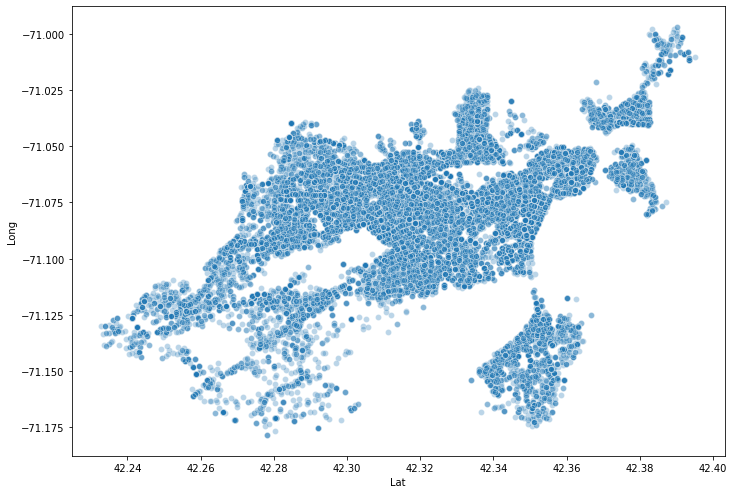

In [ ]:
# Simple scatterplot
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='Lat',
               y='Long',
                alpha=0.3,
               data=data, ax=ax)

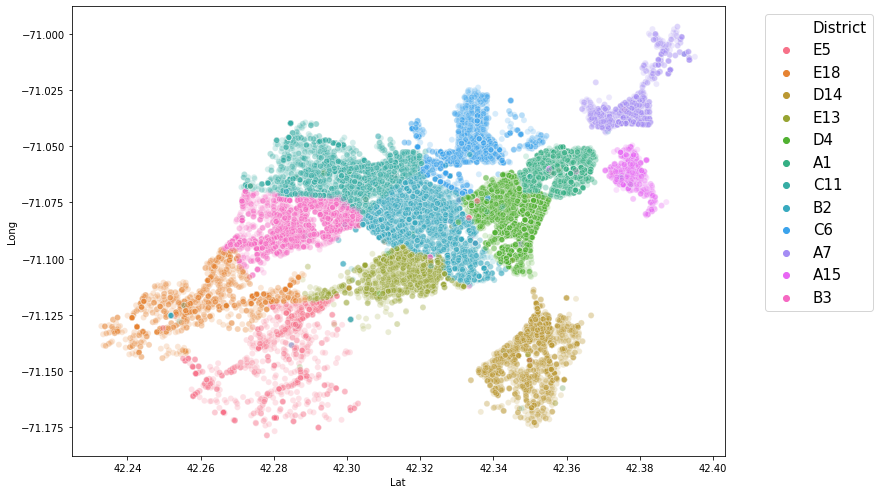

In [ ]:
# Plot districts
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='Lat',
               y='Long',
                hue='District',
                alpha=0.2,
               data=data, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=15)

###We can now associate high crime rates with particular districts, most noteably A1 and D4, which correspond to the most crowded areas of downtown Boston. There is also a very high crime region visibe in district D14.

In [ ]:
# Create basic Folium crime map
crime_map = folium.Map(location=[42.3125,-71.0875], 
                       tiles = "Stamen Toner",
                      zoom_start = 11)

# Add data for heatmp 
data_heatmap = data[data.Year == 2017]
data_heatmap = data[['Lat','Long']]
data_heatmap = data.dropna(axis=0, subset=['Lat','Long'])
data_heatmap = [[row['Lat'],row['Long']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crime_map)

# Plot!
crime_map

ABOUT LARCENY

Most of them around Newburry Street, Boylston Street, State Street and Downtown Crossing



In [ ]:
from folium.plugins import HeatMap

map_hooray = folium.Map(location=[42.361145,-71.057083],
                    zoom_start = 12, min_zoom=12, tiles= "Stamen Toner" ) #Giving the location just write boston coordinat to google

heat_df = data[(data['Year']==2017 )& (data['Group']=='Larceny')]# I take 2017 cause there is more crime against to other years
# heat_df = data[data['Group']=='Larceny'] 
heat_df = heat_df[['Lat', 'Long']] #giving only latitude and longitude now in heat_df just latitude and longitude
                                        #from 2017 larceny responde
heat_df=heat_df.dropna()
folium.CircleMarker([42.356145,-71.064083],
                    radius=50,
                    popup='Homicide',
                    color='red',
                    ).add_to(map_hooray) #Adding mark on the map but it's hard to find correct place. 
                                         #it's take to muhc time
    
    
heat_data = [[row['Lat'],row['Long']] for index, row in heat_df.iterrows()]
#We have to give latitude and longitude like this [[lat, lon],[lat, lon],[lat, lon],[lat, lon],[lat, lon]]

HeatMap(heat_data, radius=10).add_to(map_hooray) #Adding map_hooray to HeatMap
map_hooray #Plotting


##MOTOR VEHICLE ACCIDENT RESPONSE

In [ ]:

map_hooray = folium.Map(location=[42.361145,-71.057083],
                    zoom_start = 12, min_zoom=12, tiles= "Stamen Toner" )

heat_df = data[(data['Year']==2017 )& (data['Group']=='Larceny From Motor Vehicle')]# I Used 2017 cause there is more crime against to other years
heat_df = heat_df[['Lat', 'Long']]
heat_df = heat_df.dropna()

folium.CircleMarker([42.356145,-71.064083],
                    radius=50,
                    popup='Homicide',
                    color='red',
                    ).add_to(map_hooray) #Adding mark on the map but it's hard to find correct place. 
                                         #it's take to muhc time

heat_data = [[row['Lat'],row['Long']] for index, row in heat_df.iterrows()]
HeatMap(heat_data, radius=10).add_to(map_hooray)
map_hooray

Robbery Cases

In [ ]:
map_hooray = folium.Map(location=[42.361145,-71.057083],
                    zoom_start = 12, min_zoom=12, tiles= "Stamen Toner" )

heat_df = data[(data['Year']==2017 )& (data['Group']=='Robbery')]# I take 2017 cause there is more crime against to other years
heat_df = heat_df[['Lat', 'Long']]
heat_df = heat_df.dropna()

folium.CircleMarker([42.356145,-71.064083],
                    radius=50,
                    popup='Homicide',
                    color='red',
                    ).add_to(map_hooray) #Adding mark on the map but it's hard to find correct place. 
                                         #it's take to muhc time

heat_data = [[row['Lat'],row['Long']] for index, row in heat_df.iterrows()]
HeatMap(heat_data, radius=10).add_to(map_hooray)
map_hooray


Conclusions from this EDA shows:

Larceny is by far the most common type of serious crime.
Serious crimes are most likely to occur in the afternoon and evening.
Serious crimes are most likely to occur on Friday and least likely to occur on Sunday.
Serious crimes are most likely to occur in the summer and early fall, and least likely to occur in the winter (with the exeption of January, which has a crime rate more similar to the summer).
There is no obvious connection between major holidays and crime rates.
Serious crimes are most common in the city center, especially districts A1 and D4.


Learn more about [Folium](https://python-visualization.github.io/folium/) 